# Exploring MzML files with the MS Ontology

In this example, we will learn how to use `pronto` to extract a hierarchy from the MS Ontology, a controlled vocabulary developed by the Proteomics Standards Initiative to hold metadata about Mass Spectrometry instrumentation and other Protein Identification and Quantitation software. This example is taken from a real situation that kickstarted the development of `pronto` to extract metadata from [MzML files](http://www.psidev.info/mzML), a file format for Mass Spectrometry data based on XML.

## Loading `ms.obo`

The MS ontology is available online on the [OBO Foundry](http://www.obofoundry.org/ontology/ms.html), so unless we are using a local version we can simply use the version found online to load the OBO file. We may get some encoding warnings since `ms.obo` imports some legacy ontologies, but we should be OK for the most part since we are only querying terms directly.

In [1]:
import pronto
ms = pronto.Ontology.from_obo_library("ms.obo")

/home/althonos/.local/lib/python3.7/site-packages/pronto/parsers/base.py:48: UnicodeWarning: could not find encoding, assuming UTF-8
  self.ont.timeout,


## Displaying a class hierarchy with Vega

The MS ontology contains a catalog of several instruments, grouped by instrument manufacturers, but not all instruments are at the same depth level. We can easily use the `Term.subclasses` method to find all instruments defined in the controlled vocabulary. Let's then build a tree from all the subclasses of `MS:1000031`:

In [2]:
instruments = set(ms['MS:1000031'].subclasses())
data = []

for term in instruments:
    value = {"id": int(term.id[3:]), "name": term.id, "desc": term.name}   
    parents = instruments.intersection(term.relationships.get(ms['is_a'], set()))
    if parents:
        value['parent'] = int(parents.pop().id[3:])
    data.append(value)

Now that we have our tree structure, we can render it simply with [Vega](https://vega.github.io/) to get a better idea of the classes we are inspecting:

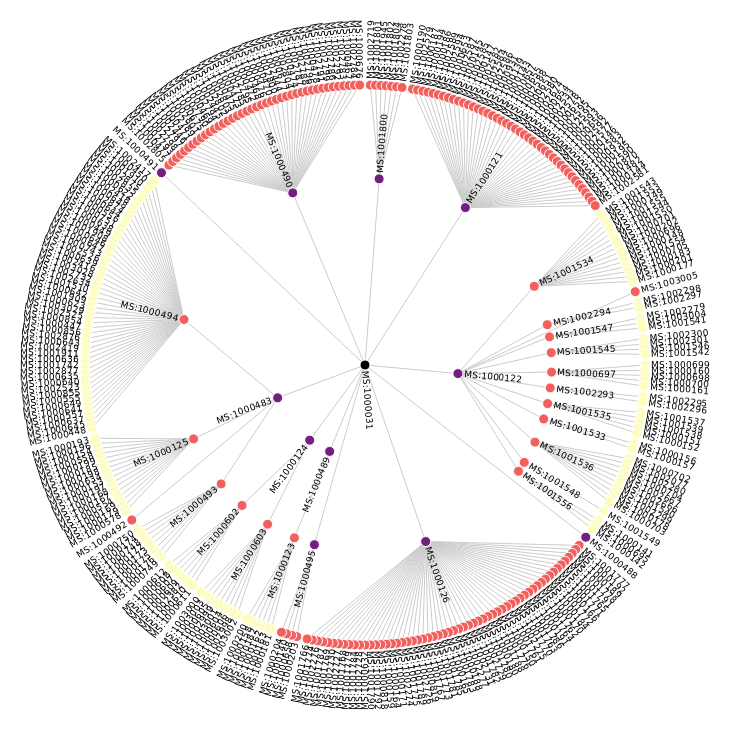

In [3]:
import json
import urllib.request
from vega import Vega

# Let's use the Vega radial tree example as a basis of the visualization
view = json.load(urllib.request.urlopen("https://vega.github.io/vega/examples/radial-tree-layout.vg.json"))

# First replace the default data with our own
view['data'][0].pop('url')
view['data'][0]['values'] = data
view['marks'][1]['encode']['enter']['tooltip'] = {"signal": "datum.desc"}
view['signals'][4]['value'] = 'cluster'

# Render the clustered tree
Vega(view)

## Extracting the instruments from an MzML file

MzML files store the metadata corresponding to one or several MS scans using the MS controlled vocabulary, but the location and type of metadata can vary and needs to be extracted from a term subclassing hierarchy. Let's download an example file from the MetaboLights library and parse it with `xml.etree`:

In [4]:
import urllib.request
import xml.etree.ElementTree as etree

URL = "http://ftp.ebi.ac.uk/pub/databases/metabolights/studies/public/MTBLS341/pos_Exp2-K3_2-E,5_01_7458.d.mzML"
mzml = etree.parse(urllib.request.urlopen(URL))

Now we want to extract the instruments that were used in the MS scan, that are stored as `mzml:cvParam` elements: we build a set of all the instruments in the MS ontology, and we iterate over the instruments `mzml:cvParam` to find the ones that refer to instruments:

In [5]:
instruments = {term.id for term in ms["MS:1000031"].subclasses()}
study_instruments = []

path = "mzml:instrumentConfigurationList/mzml:instrumentConfiguration/mzml:cvParam"
for element in mzml.iterfind(path, {'mzml': 'http://psi.hupo.org/ms/mzml'}):
    if element.attrib['accession'] in instruments:
        study_instruments.append(ms[element.attrib['accession']])
        
print(study_instruments)

[Term('MS:1000703', name='micrOTOF-Q')]


Finally we can extract the manufacturer of the instruments we found by checking which one of its superclasses is a direct child of the `MS:1000031` term:

In [6]:
study_manufacturers = []

for instrument in study_instruments:
    for sup in instrument.superclasses():
        if ms['MS:1000031'] in sup.relationships.get(ms['is_a'], ()):
            study_manufacturers.append(sup)
            break

print(study_manufacturers)

[Term('MS:1000122', name='Bruker Daltonics instrument model')]


## Validating the controlled vocabulary terms in an MzML file

All `mzml:cvParam` XML elements are required to have the 3 following attributes:
* `accession`, which is the identifier of the term in one of the ontologies imported in the file
* `cvRef`, which is the identifier of the ontology imported in the file
* `name`, which is the textual definition of the term

`name` in particular is redundant with respect to the actual ontology file, but can help rendering the XML elements. However, some MzML files can have a mismatch between the `name` and `accession` attributes. In order to check these mismatches we can use `pronto` to retrieve the name of all of these controlled vocabulary terms.

In [7]:
mismatches = [
    element
    for element in mzml.iter()
    if element.tag == "{http://psi.hupo.org/ms/mzml}cvParam"
    if element.get('accession') in ms
    if ms[element.get('accession')].name != element.get('name')
]

In [8]:
for m in mismatches:
    print(f"{m.get('accession')}: {m.get('name')!r} (should be {ms[m.get('accession')].name!r})")

MS:1000815: 'Bruker BAF file' (should be 'Bruker BAF format')
MS:1000590: 'contact organization' (should be 'contact affiliation')
